<a href="https://colab.research.google.com/github/VVdovichev/ML_in_Business/blob/main/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [277]:
#!pip install shap
!pip install catboost

In [278]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report
import shap

# load JS visualization code to notebook
shap.initjs()

##__1.__ взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [279]:
list_column_names = ['variance of Wavelet Transformed image',
                     'skewness of Wavelet Transformed image',
                     'curtosis of Wavelet Transformed image',
                     'entropy of image',
                     'class']
df = pd.read_csv('data_banknote_authentication.txt', names=list_column_names)
df.head()

,variance of Wavelet Transformed image,skewness of Wavelet Transformed image,curtosis of Wavelet Transformed image,entropy of image,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


##__2.__ сделать обзорный анализ выбранного датасета

In [280]:
df.describe()

,variance of Wavelet Transformed image,skewness of Wavelet Transformed image,curtosis of Wavelet Transformed image,entropy of image,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   variance of Wavelet Transformed image  1372 non-null   float64
 1   skewness of Wavelet Transformed image  1372 non-null   float64
 2   curtosis of Wavelet Transformed image  1372 non-null   float64
 3   entropy of image                       1372 non-null   float64
 4   class                                  1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [282]:
df.isna().sum()

variance of Wavelet Transformed image    0
skewness of Wavelet Transformed image    0
curtosis of Wavelet Transformed image    0
entropy of image                         0
class                                    0
dtype: int64

In [283]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

В датасете нет выбросов и пропусков, классы сбалансированы.

##__3.__ сделать feature engineering

In [284]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

##__4.__ обучить любой классификатор (какой вам нравится)

In [285]:
model = CatBoostClassifier(random_state=7)
model.fit(X_train, y_train)


Learning rate set to 0.010124
0:	learn: 0.6759544	total: 4.62ms	remaining: 4.62s
1:	learn: 0.6589252	total: 8.92ms	remaining: 4.45s
2:	learn: 0.6425767	total: 15.2ms	remaining: 5.06s
3:	learn: 0.6276309	total: 16.9ms	remaining: 4.21s
4:	learn: 0.6113901	total: 18.8ms	remaining: 3.73s
5:	learn: 0.5940193	total: 20.5ms	remaining: 3.4s
6:	learn: 0.5822572	total: 22.3ms	remaining: 3.17s
7:	learn: 0.5656744	total: 24.6ms	remaining: 3.05s
8:	learn: 0.5533824	total: 26.4ms	remaining: 2.91s
9:	learn: 0.5389894	total: 28.2ms	remaining: 2.8s
10:	learn: 0.5277047	total: 30ms	remaining: 2.7s
11:	learn: 0.5126769	total: 31.7ms	remaining: 2.61s
12:	learn: 0.4992264	total: 33.5ms	remaining: 2.54s
13:	learn: 0.4861698	total: 35.5ms	remaining: 2.5s
14:	learn: 0.4733096	total: 37.3ms	remaining: 2.45s
15:	learn: 0.4620792	total: 39.1ms	remaining: 2.4s
16:	learn: 0.4510095	total: 40.7ms	remaining: 2.35s
17:	learn: 0.4430975	total: 42.5ms	remaining: 2.32s
18:	learn: 0.4339808	total: 44.2ms	remaining: 2.28s

In [286]:
#наши прогнозы для тестовой выборки
preds = model.predict(X_test)

In [287]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       229
           1       0.99      1.00      0.99       183

    accuracy                           1.00       412
   macro avg       0.99      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412



##__5.__ разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)

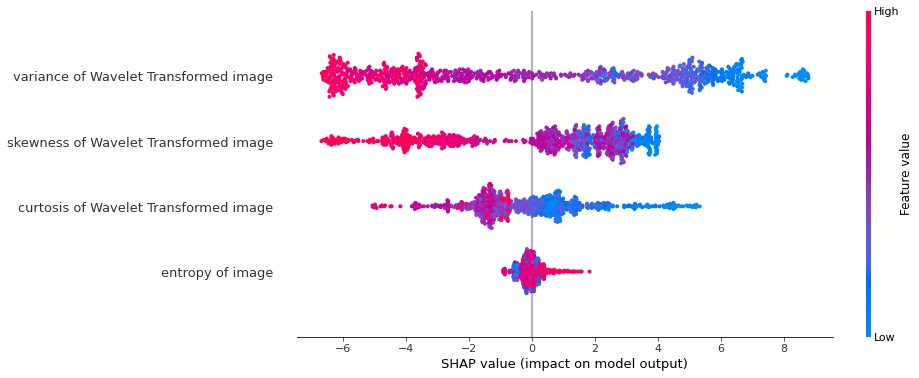

In [288]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_size=(12, 6))

Высокие значения признаков "variance of Wavelet Transformed image", "skewness of Wavelet Transformed image" и "curtosis of Wavelet Transformed image" говорят о подлинности купюр.

##-для топ 10%

In [294]:
top_10 = int(X_train.shape[0] / 10)

In [295]:
explainer = shap.TreeExplainer(model, X_train.iloc[:top_10, :], feature_names=X_train.columns)

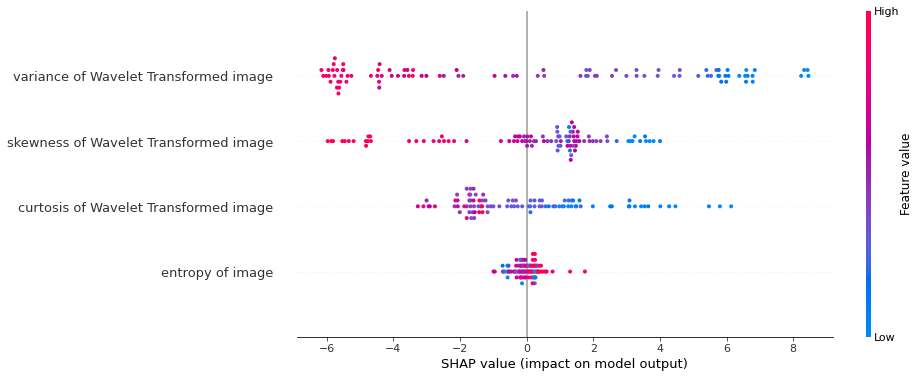

In [296]:
shap_values = explainer.shap_values(X_train.iloc[:top_10, :])

shap.summary_plot(shap_values, X_train.iloc[:top_10, :], plot_size=(12, 6))

##- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат